In [3]:
from utils import *
warnings.filterwarnings('ignore')
%matplotlib inline


In [4]:
fd_collection = getCollection("team_5_mwdb_phase_2", "fd_collection")


In [5]:
from tkinter.filedialog import askopenfilename
import tkinter
from torchvision.io import read_image


## !feature extraction for full database!

In [10]:
start = 0
stop = len(dataset)
step = 2  # even-numbered image IDs only

for idx in range(start, stop, step):
    image_fd = get_all_fd(idx)

    # Store to collection (update if existing)
    fd_collection.update_one(
        {"image_id": idx},
        {"$set": image_fd},
        upsert=True,
    )


c:\Users\rknar\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


### Get input as image ID (dataset) or from image file

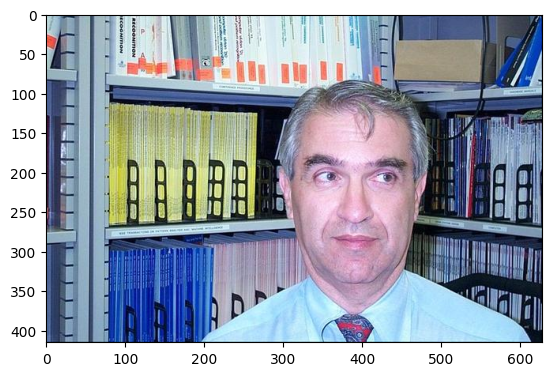

Showing 10 similar images for image ID 101, using pearson_distance_measure for fc feature descriptor...


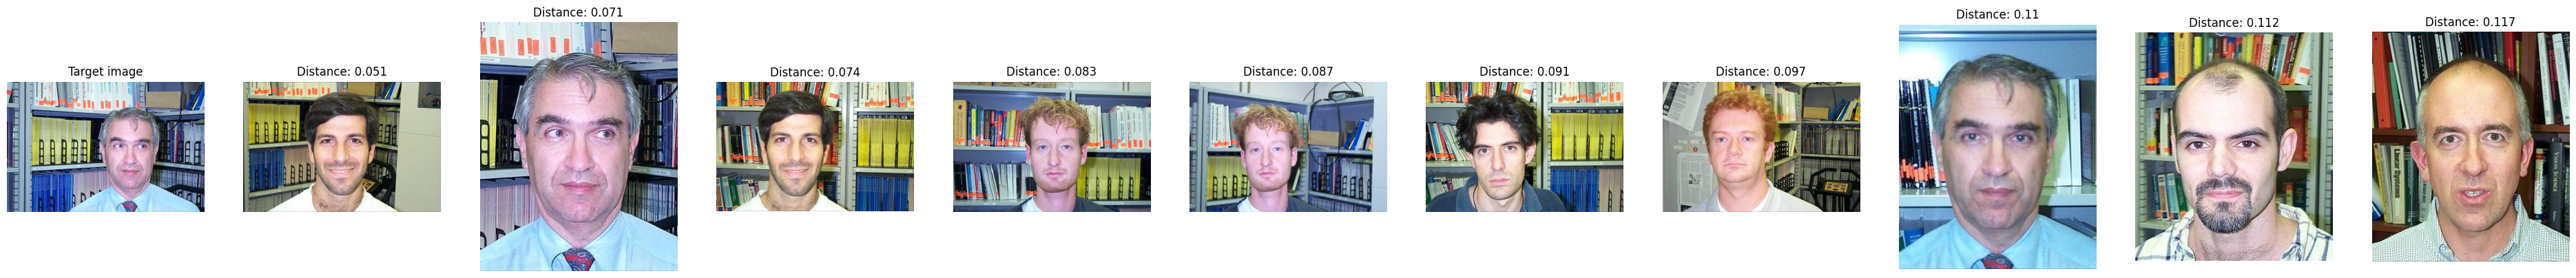

In [6]:
selected_image_id = int(
    input("Enter image ID: (-1 if you want to select an image file)")
)
if selected_image_id == -1:
    # pick image and get label using tkinter
    root = tkinter.Tk()
    root.attributes("-topmost", True)
    selected_image_path = askopenfilename(title="Select Image File")
    root.withdraw()
    print(selected_image_path)
    sample_image = read_image(selected_image_path).div(255)  # scale to [0,1] range
    sample_label = int(input("Enter image label number: (0 to 100)"))
else:
    # get image and label from dataset
    sample_image, sample_label = dataset[selected_image_id]

# Show selected image
plt.imshow(transforms.ToPILImage()(sample_image))
plt.show()

k = int(input("Enter value of k: "))
if k < 1:
    raise ValueError("k should be a positive integer")

selected_feature_model = valid_feature_models[
    str(input("Enter feature model - one of " + str(list(valid_feature_models.keys()))))
]

selected_distance_measure = valid_distance_measures[
    str(input("Enter distance measure - one of " + str(list(valid_distance_measures.keys()))))
]

if selected_image_id == -1:
    show_similar_images_for_image(
        fd_collection,
        -1,
        sample_image,
        sample_label,
        k,
        selected_feature_model,
        selected_distance_measure,
        save_plots=False,
    )
else:
    show_similar_images_for_image(
        fd_collection,
        selected_image_id,
        None,
        None,
        k,
        selected_feature_model,
        selected_distance_measure,
        save_plots=False,
    )
